<a href="https://colab.research.google.com/github/larrygoyeau/bubble_segmentation_Mask_RCNN/blob/master/Mask_RCNN_automatic_segementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bubble segementation using Mask RCNN: inference model

In [ ]:
#@title Run this block (click on this text and Ctrl+Entre). This will install the framwork. { run: "auto" }

import logging
logging.getLogger('tensorflow').disabled = True

#To fix the version of tensorflow:
%tensorflow_version 1.x
%matplotlib inline 

import os
os.system('git clone https://github.com/larrygoyeau/Mask_RCNN')
os.system('pip install -r /content/Mask_RCNN/requirements.txt')

import sys
sys.path.append('/content/Mask_RCNN')

import resource
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from skimage.measure import find_contours
from matplotlib.patches import Polygon
import requests
from IPython.display import HTML, Image, clear_output
from google.colab.output import eval_js
from base64 import b64decode
from google_drive_downloader import GoogleDriveDownloader as gdd
import copy

# Root directory of the project
ROOT_DIR = os.path.abspath("/content")

# Import Mask RCNN
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn import visualize

# To increas the recursion limite
resource.setrlimit(resource.RLIMIT_STACK, [0x100000000, resource.RLIM_INFINITY])
sys.setrecursionlimit(0x1000000)

class InferenceConfig(Config):
    # Give the configuration a recognizable name
    NAME = "shapes"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_RESIZE_MODE = "pad64"
    RPN_NMS_THRESHOLD = 0.55
    DETECTION_MAX_INSTANCES=350
    MAX_GT_INSTANCES=350
    DETECTION_MIN_CONFIDENCE=0

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shape

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512


    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

inference_config = InferenceConfig()

MODEL_PATH = '/content/model.h5'

# Download trained weights from Releases if needed
###### Important: If you want to change the trained model, replace the file_id below.
###### For example if your shared link is https://drive.google.com/file/d/16m6o97REebp_C86IbjbaHitxUvjBjrBe/view?usp=sharing
###### the file_id will be 16m6o97REebp_C86IbjbaHitxUvjBjrBe

if not os.path.exists(MODEL_PATH):
  gdd.download_file_from_google_drive(file_id='16m6o97REebp_C86IbjbaHitxUvjBjrBe',
                                    dest_path=MODEL_PATH,
                                    unzip=False)

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights
model.load_weights(MODEL_PATH, by_name=True)

def remove_bubble(mask,i,j,I,J,color):
  '''Remouve the bubble that contain (i,j) of color random_color'''
  if mask[i,j]==color:
    mask[i,j]=255
    if 0<j:
      remove_bubble(mask,i,j-1,I,J,color)
    if i<I-1:
      remove_bubble(mask,i+1,j,I,J,color)
    if 0<i:
      remove_bubble(mask,i-1,j,I,J,color)
    if j<J-1:
      remove_bubble(mask,i,j+1,I,J,color)

def creat_mask(image_name,instance_mask,remove_bubbles_on_the_border,boxes):
  ''' This function will return the superposition of all instance masks to a unique mask
   but with each bubble having a different color to be able to distinguish them one the mask.
   If remove_bubbles_on_the_border is true, the bubbles on the border are removed'''
  N=len(instance_mask[0][0])
  I=len(instance_mask)
  J=len(instance_mask[0])
  mask=np.ones(instance_mask[...,0].shape)*255
  size_list=[]
  border=[]
  bubble=-1
  for n in range(N):
    color=random.randint(1, 235)
    size=0
    for i in range(I):
      for j in range(J):
        if instance_mask[i,j,n]:
          margin=3
          if i<margin or j<margin or i>I-margin or j>J-margin:
            if bubble!=n:
              border=border+[(i,j,n)]
              bubble=n
          mask[i,j]=color
          size=size+1
    size_list=size_list+[size]
  if remove_bubbles_on_the_border:
    k=0  
    for b in border:
      i,j,n=b
      if mask[i,j]!=255:
        remove_bubble(mask,i,j,I,J,mask[i,j])
        del size_list[n-k]
        instance_mask=np.delete(instance_mask, n-k, 2)
        boxes=np.delete(boxes, n-k, 0)
        k=k+1
  file = open(image_name[:-4]+".txt","w")
  file.write("Bubble index and its size\n")
  n=len(size_list)
  for i in range(n):
    file.write(str(i)+"  "+str(size_list[i])+"\n")
  file.close()
  return mask, size_list,instance_mask, boxes


def display_instances(ax,image_name,image, boxes, masks, class_ids, class_names,
                      scores=None,
                      show_mask=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    show_mask: To show masks and bounding boxes or not
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # Generate random colors
    colors = colors or visualize.random_colors(N)

    # Show area outside image boundaries.

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = visualize.apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)

    cv2.imwrite('mask_plus_'+image_name[:-3]+'png', masked_image.astype(np.uint8))
    ax.imshow(masked_image.astype(np.uint8))
    ax.set_title("Number of detected bubbles "+str(len(masks[0][0])))
    ax.title.set_fontsize(25)

def show_and_save_segmentation(file_names):
  size_all_bubbles=[]
  mask_plus_image=[]
  size_images=[]
  images_list=[]
  images_list_color=[]
  n=len(file_names)
  fig, axarr = plt.subplots(n,1,figsize=(15, 9*n))
  i=0
  for image_name in file_names:
    path=os.path.join('/content', image_name)
    image=cv2.imread(path)
    images_list=images_list+[cv2.imread(path,0)]
    images_list_color=images_list_color+[cv2.imread(path)]
    size_images=size_images+[image.shape[0]*image.shape[1]]
    path=path.replace(' ', '\ ')
    os.system('rm '+path)
    # Run detection
    results = model.detect([image], verbose=1)
    r = results[0]
    mask, size_list, instance_mask, boxes=creat_mask(image_name,r['masks'],remove_bubbles_on_the_border,r['rois'])
    cv2.imwrite('mask_of_'+image_name[:-3]+'png', mask)
    size_all_bubbles=size_all_bubbles+size_list
    if len(file_names)==1:
      ax=axarr
    else:
      ax=axarr[i]
    display_instances(ax,image_name,image, boxes, instance_mask , np.ones((len(instance_mask[0][0]))).astype(int), 
                            ['BG', ' '], np.zeros((len(instance_mask[0][0]))))
    i=i+1
    print("Number of detected bubbles "+str(len(instance_mask[0][0])))
  plt.show()
  return(size_all_bubbles,size_images,images_list,images_list_color)

#The following functions will create the interface for the hand drawing.

canvas_html = """
<canvas width=%d height=%d></canvas>
<br>
<button>Next image</button>
<button onclick="undo()">Undo</button>
<button onclick="Remove_bubble()">Remove bubbles</button>
<button onclick="Add_bubble()">Add bubbles</button>
<p>Brush size:</p>
<input name="brush" id="brush_size" type="range" value="0"  min="0" max="20" />
<p>Zoom:</p>
<input name="Zoom" id="Zoom" type="range" value="%d"  min="1" max="6" />

<style>
canvas {
  image-rendering: pixelated;
}
</style>

<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

s = Zoom.value;
canvas.style.width = s*canvas.width+'px'
canvas.style.height = s*canvas.height+'px'
Zoom.oninput = function() {
  s = Zoom.value;
  canvas.style.width = s*canvas.width+'px'
  canvas.style.height = s*canvas.height+'px'
}

var button = document.querySelector('button')
ctx.strokeStyle='#ff0000';

var cPushArray = new Array();

var cStep = -1;
function undo() {
    if (cStep > 0) {
        cStep--;
        var canvasPic = new Image();
        canvasPic.src = cPushArray[cStep];
        canvasPic.onload = function () { ctx.drawImage(canvasPic, 0, 0); }
        list_of_remove.pop()
    }
}
function cPush() {
    cStep++;
    if (cStep < cPushArray.length) { cPushArray.length = cStep; }
    cPushArray.push(canvas.toDataURL());
}

const imageData = ctx.createImageData(canvas.width, canvas.height);
var image = %s;
var original_image= %s;
var mask = %s;
// Iterate through every pixel
k=0
for (let i = 0; i < imageData.data.length; i += 4) {
  // Modify pixel data
  imageData.data[i + 0] = image[i-k];  // R value
  imageData.data[i + 1] = image[i+1-k];    // G value
  imageData.data[i + 2] = image[i+2-k];  // B value
  imageData.data[i + 3] = 255;  // A value
  k=k+1
}

// Draw image data to the canvas
ctx.putImageData(imageData,0,0);

function Add_bubble() {
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})

brush_size.oninput = function() {
  ctx.lineWidth = brush_size.value;
}

canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(Math.trunc(1/s*mouse.x)+0.5,Math.trunc( 1/s*mouse.y)+0.5)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
k=0
cPush()
var onPaint = ()=>{
  if (k/50==Math.trunc(k/50)){
    cPush()
  }
  ctx.lineTo(Math.trunc(1/s*mouse.x)+0.5, Math.trunc(1/s*mouse.y)+0.5)
  ctx.stroke()
  k++
}
}

Add_bubble()

list_of_remove=[]
function Remove_bubble() {
  function uncolor_bubble(x,y,color_bubble,color_liquide){
    if (mask[y*canvas.width*3+0+x*3]==color_bubble && mask[y*canvas.width*3+0+x*3]!=color_liquide){
      r=original_image[y*canvas.width*3+0+x*3]
      g=original_image[y*canvas.width*3+1+x*3]
      b=original_image[y*canvas.width*3+2+x*3]
      ctx.fillStyle = "rgba("+r+","+g+","+b+","+255+")"
      ctx.fillRect( x, y, 1, 1 )
      mask[y*canvas.width*3+0+x*3]=color_liquide
      if (0<y){
        uncolor_bubble(x,y-1,color_bubble,color_liquide)}
      if (0<x){
        uncolor_bubble(x-1,y,color_bubble,color_liquide)}
      if (x<canvas.width-1){
        uncolor_bubble(x+1,y,color_bubble,color_liquide)}
      if (y<canvas.height-1){
        uncolor_bubble(x,y+1,color_bubble,color_liquide)}
      }
    }
  cPush()
  canvas.onmousedown = ()=>{
    var x = Math.trunc(1/s*(event.clientX-5))
    var y = Math.trunc(1/s*(event.clientY-7.5))
    list_of_remove.push([y,x])
    var copy_mask= [...mask]
    uncolor_bubble(x,y,mask[y*canvas.width*3+0+x*3],255)
    mask=copy_mask
    cPush()
  }
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve([list_of_remove,
      canvas.toDataURL('image/png',1)]
      )
  }
})
</script>
"""

def draw(image_flat, original_image_flat, mask_flat, filename='drawing.png', w=800, h=400, line_width=1,scale=4):
  '''Plot the image to be corrected by the user and save the final image'''
  display(HTML(canvas_html % (w, h,scale, image_flat, original_image_flat, mask_flat)))
  data = eval_js("data")
  binary = b64decode(data[1].split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return(data[0])

#The user will draw the missed bubbles in red and threshold_red is here to separet what is new on the image.
threshold_red=30

def size_and_add_bubble(image,i,j,I,J):
  '''Remove bubble that contain (i,j) and return its size'''
  if 255-threshold_red<image[i,j][2] and image[i,j][1]<threshold_red and image[i,j][0]<threshold_red:
    image[i,j]=0
    size=1
    if 0<j:
      size=size+size_and_add_bubble(image,i,j-1,I,J)
    if i<I-1:
      size=size+size_and_add_bubble(image,i+1,j,I,J)
    if 0<i:
      size=size+size_and_add_bubble(image,i-1,j,I,J)
    if j<J-1:
      size=size+size_and_add_bubble(image,i,j+1,I,J)
    return(size)
  else:
    return(0)

def size_and_remove_bubble(mask,i,j,I,J,color):
  '''Remouve the bubble that contain (i,j)'''
  if mask[i,j][0]==color[0] and mask[i,j][0]!=255:
    mask[i,j]=255
    size=1
    if 0<j:
      size=size+size_and_remove_bubble(mask,i,j-1,I,J,color)
    if i<I-1:
      size=size+size_and_remove_bubble(mask,i+1,j,I,J,color)
    if 0<i:
      size=size+size_and_remove_bubble(mask,i-1,j,I,J,color)
    if j<J-1:
      size=size+size_and_remove_bubble(mask,i,j+1,I,J,color)
    return(size)
  else:
    return(0)

def draw_missed_bubble(image_name,size_all_bubbles,original_image):
  '''Add the new bubbles to the mask and save its size'''
  image_path=os.path.join('/content','mask_plus_'+ image_name)
  mask_path=os.path.join('/content', 'mask_of_'+image_name[:-3]+'png')
  bubble_info_path=os.path.join('/content',  image_name[:-4]+".txt")
  image=cv2.imread(image_path)
  mask=cv2.imread(mask_path)
  I=len(image)
  J=len(image[0])
  image_flat=list(image.flatten())
  original_image_flat=list(original_image.flatten())
  mask_flat=list(mask.flatten())
  m=max(I,J/1.4)
  bubbles_to_remove=draw(image_flat, original_image_flat, mask_flat, image_path, w=J, h=I,scale=700/m)

  #Remouve bubbles

  for bubble in bubbles_to_remove:
    color=copy.copy(mask[bubble[0],bubble[1]])
    size_to_remove=size_and_remove_bubble(mask,bubble[0],bubble[1],I,J,color)
    already=False
    file = open(bubble_info_path,"r")
    lines = file.readlines()
    file.close()
    file = open(bubble_info_path,"w")
    for line in range(len(lines)):
      if lines[line]=='Bubble index and its size\n':
        file.write(lines[line])
      elif int(lines[line].split()[1])!=size_to_remove or already:
        file.write(str(line-1-int(already))+"  "+lines[line].split()[1]+"\n")
      else:
        already=True
    file.close()

    for size in range(len(size_all_bubbles)):
      if size_all_bubbles[size]==size_to_remove:
        del size_all_bubbles[size]
        break

  image=cv2.imread(image_path)
  #Add missed bubbles
  for i in range(I):
    for j in range(J):
      if 255-threshold_red<image[i,j][2] and image[i,j][1]<threshold_red and image[i,j][0]<threshold_red:
        mask[i,j]=[0,0,0]
  
  cv2.imwrite(mask_path,mask)

  #Add missed bubbles on the .txt file

  n_new_bubble=0
  file = open(bubble_info_path,"r")
  lines = file.readlines()
  file.close()
  n_bubble=len(lines)-1
  file = open(bubble_info_path,"a+")
  for i in range(I):
    for j in range(J):
      if 255-threshold_red<image[i,j][2] and image[i,j][1]<threshold_red and image[i,j][0]<threshold_red:
        size=size_and_add_bubble(image,i,j,I,J)
        size_all_bubbles=size_all_bubbles+[size]
        file.write(str(n_bubble+n_new_bubble)+"  "+str(size)+"\n")
        n_new_bubble=n_new_bubble+1
  
  file.close()
  return(size_all_bubbles)

remove_bubbles_on_the_border=False

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
#@title Do you want to remove the bubbles that are in contact with the outline of the images? { run: "auto" }

Select_the_answer_and_run_this_block = 'No' #@param ["Yes", "No"]

if Select_the_answer_and_run_this_block=='Yes':
  remove_bubbles_on_the_border=True
else:
  remove_bubbles_on_the_border=False

Now run the block below. Then click on “select fichiers” and select (several) images that you want to segment from your device. The segmented images are saved on the left panel 'fichier'. Click on 'actualliser' and the file will appear. These files are:


*   mask_plus_image_name.png $ $ $ $ for the segmentation plus the image
*   mask_of_image_name.png $ $ $ $ for the mask only
* image_name.txt $ $ $ $ for the description of each bubble detected on the image



 You can download these files by right clicking on them and select 'telecharger'.


Saving frame4887.png to frame4887.png
Processing 1 images
image                    shape: (128, 128, 3)         min:   61.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:  -62.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Number of detected bubbles 36


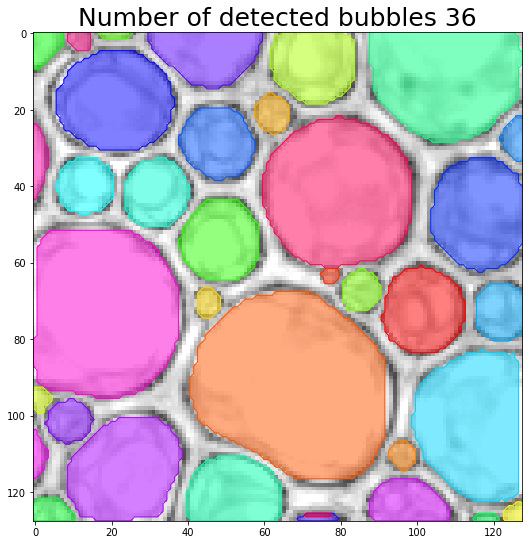

In [ ]:
#@title Run this block { run: "auto" }

file_names = files.upload()

size_all_bubbles,size_images,images_list,images_list_color=show_and_save_segmentation(file_names)

# Manual modifications.
The below block allow you to add and remove bubbles on the previous automatic segmentation. To add a bubble you have to draw it with your mouse. To remove bubbles click on the button 'Remove bubbles' and click on the bubbles that you want to remove. When you finished click on 'next image' bellow the image.

In [ ]:
#@title Run this block  { run: "auto" }
i=0
for image_name in file_names:
  size_all_bubbles=draw_missed_bubble(image_name[:-3]+'png',size_all_bubbles,images_list_color[i])
  i=i+1
  if len(file_names)>1:
    clear_output()

def visualize_plot(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 10))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    
if len(file_names)>1:
  for image_name in file_names:
    print('Your drawing appear in bleu')
    image_path=os.path.join('/content','mask_plus_'+ image_name[:-3]+'png')
    image=cv2.imread(image_path)
    visualize_plot(mask_plus_image=denormalize(image.squeeze()))

# Aditional statistics on foam images
'size_all_bubbles' is the list of the size of all bubbles in all the images that you selected. By running the block below, you will get the distribution of the size. The historame is saved as size_distribution.png

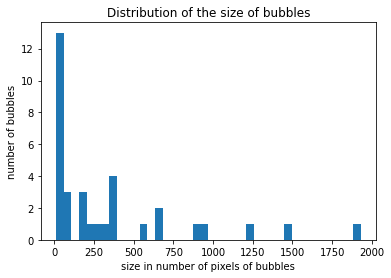

In [ ]:
plt.hist(size_all_bubbles,bins = 40)
plt.xlabel('size in number of pixels of bubbles')
plt.ylabel('number of bubbles')
plt.title('Distribution of the size of bubbles')
plt.savefig("/content/size_distribution.png")

In [ ]:
if not remove_bubbles_on_the_border:
  print('The proportion of air is '+str(round(sum(size_all_bubbles)/sum(size_images),3)))

The proportion of air is 0.676


# Some useful instructions:

*   It's recomended to use a GPU to increas the speed of segmentation. You can check it on >>execution>>modifier le type d'execution>>accélérateur>>materiel>>GPU
*   If you want to train the model using the mask with the manual ameliorations, open the notbook 'train_Mask_RCNN.ipynb' in [github](https://github.com/larrygoyeau/bubble_segmentation_Mask_RCNN) and add the mask and its corresponding image as explained in the notbook.
*   If you want to have a look on the code, double click on blocks. Save a copy of this notbook to your drive and be free to add any code and functionalities!
*   This programme uses some libraries that are already installed in colab. This means that it may happen in the future that some update of these libraries became incompatible with the segmentation framework. If needed you can add at the top of the source code the line '!pip install 'name of the library'=='verssion of the required library'' . The versions of the required libraries are recorded in 'Package used for Mask RCNN.pdf' in [github](https://github.com/larrygoyeau/bubble_segmentation_Mask_RCNN).
*   If you get some troubles, please contact me: larry.goyeau@gmail.com




# Refine contours using active contours (only if the bubbles that are in contact with the outline of the images are removed).
Copyright Georges Quénot - CNRS-LIG

In [ ]:
#@title Run this block to install the framework
# This software comes without any Guarantee
# Version 3 - 2020-03-13

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from scipy import interpolate as inpo
from scipy import signal
import scipy.ndimage.filters
import time
from skimage import measure

def qbubbleLabels(mask):
    return(measure.label(mask, background=0))

def qbubbleLabelAreas(labels):
    nl = labels.max()
    return(list(np.histogram(labels, bins = nl, range = (0.5, nl+0.5))[0]))

def qbubbleLabelsContours(labels):
    # Makes a list of contours from an image of labeled (numbered) regions
    lv = []
    for i in range(np.max(labels)):
        inside = np.equal(labels,i+1)
        lv.append(qbubbleInsideContour(inside))
    return(lv)

def qbubbleSplit(v):
    # Order in v is: xc, yc, a0, a1, a2, ..., aI, b1, b2, ..., bI
    I = (v.size-3)//2
    (xc, yc, a0), a, b = v[0:3], v[3:I+3], v[I+3:]
    return((xc, yc, a0, a, b, I))

def qbubblePointInside(v, x, y, m = 0):
    # Tells whether a point is inside a contour spline with a margin of m pixels
    xc, yc, r, a, b, I = qbubbleSplit(v)
    t = math.atan2(y-yc, x-xc)
    for i in range(0, I): r += a[i]*math.cos((i+1)*t)+b[i]*math.sin((i+1)*t)
    return((x-xc)**2+(y-yc)**2 < (r+m)**2)

def qbubbleImageInside(v, w, h, m = 0):
    # Builds a boolean image of points inside a contour with a margin of m pixels
    xc, yc, r, a, b, I = qbubbleSplit(v)
    dx = np.repeat(np.expand_dims((np.array(range(w))+0.5), axis = 0), h, axis = 0)-xc
    dy = np.repeat(np.expand_dims((np.array(range(h))+0.5), axis = 1), w, axis = 1)-yc
    r = np.repeat(np.expand_dims(r, axis = 0), h, axis = 0)
    r = np.repeat(np.expand_dims(r, axis = 1), w, axis = 1)
    t = np.arctan2(dy, dx)
    for i in range(0, I): r += a[i]*np.cos((i+1)*t)+b[i]*np.sin((i+1)*t)
    return(np.less(np.square(dx)+np.square(dy), np.square(r+m)))

def qbubbleImageContour(inside):
    # Create a fuzzy contour image for contour spline search from a binary image
    h, w = inside.shape
    x = np.repeat(np.expand_dims((np.array(range(w))+0.5), axis = 0), h, axis = 0)
    y = np.repeat(np.expand_dims((np.array(range(h))+0.5), axis = 1), w, axis = 1)
    a = np.sum(inside)
    xg = np.sum(x*inside)/a
    yg = np.sum(y*inside)/a
    simg = 1.0-scipy.ndimage.filters.gaussian_filter(1.0*inside, sigma=2.0)
    sdx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = 'float32')/4
    sdy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = 'float32')/4
    sdx_img = signal.convolve2d(simg, sdx, boundary='symm', mode='same')
    sdy_img = signal.convolve2d(simg, sdy, boundary='symm', mode='same')
    sdm_img = np.sqrt(np.square(sdx_img)+np.square(sdy_img))
    return(((1-sdm_img/np.amax(sdm_img)), xg, yg, math.sqrt(a/math.pi)))

def qbubbleIoU(v1, v2, w, h):
    # Compute IoU between delimited regions
    inside1 = qbubbleImageInside(v1, w, h)
    inside2 = qbubbleImageInside(v2, w, h)
    u = np.sum(np.logical_or(inside1, inside2))
    if (u > 0): iou = np.sum(np.logical_and(inside1, inside2))/u 
    else: iou = 0
    return(iou)

def qbubbleIoUs(lv1, lv2, w, h):
    # Compute IoUs between delimited regions
    iou = []
    for i in range(len(lv1)):
        inside1 = qbubbleImageInside(lv1[i], w, h)
        inside2 = qbubbleImageInside(lv2[i], w, h)
        u = np.sum(np.logical_or(inside1, inside2))
        if (u > 0): iou.append(np.sum(np.logical_and(inside1, inside2))/u)
        else: iou.append(0)
    return(iou)

def qbubbleIoULabels(labels, lv, w, h):
    # Compute IoUs between delimited regions
    iou = []
    for i in range(len(lv)):
        inside1 = np.equal(labels,i+1)
        inside2 = qbubbleImageInside(lv[i], w, h)
        u = np.sum(np.logical_or(inside1, inside2))
        if (u > 0): iou.append(np.sum(np.logical_and(inside1, inside2))/u)
        else: iou.append(0)
    return(iou)

def qbubbleArea(v, w, h):
    # Returns the area inside a contour and inside the image
    return(np.sum(qbubbleImageInside(v, w, h)))

def qbubbleAreas(lv, w, h):
    # Returns the areas inside contours and inside the image
    la = []
    for v in lv: la.append(np.sum(qbubbleImageInside(v, w, h)))
    return(la)

def qbubbleAreaF(v, m = 1):
    # Returns the area inside a contour
    xc, yc, a0, a, b, I = qbubbleSplit(v)
    s, n = 0, math.ceil(2*m*a0*math.pi)
    for k in range(n):
        tt, r = 2*k*math.pi/n, a0
        for i in range(I): r += a[i]*math.cos((i+1)*tt)+b[i]*math.sin((i+1)*tt)
        s += r**2
    return(s*math.pi/n)

def qbubbleTkPolygon(v, m = 1):
    # Returns a list of point coordinates for drawing the contour
    xc, yc, a0, a, b, I = qbubbleSplit(v)
    p, n = [], math.ceil(2*m*a0*math.pi)
    for k in range(n):
        tt, r = 2*k*math.pi/n, a0
        for i in range(I): r += a[i]*math.cos((i+1)*tt)+b[i]*math.sin((i+1)*tt)
        p.append([yc+r*math.sin(tt),xc+r*math.cos(tt)])
    return(p)

def qbubbleDraw(v, w, h, t = 0):
    # Returns a list of point coordinates for drawing the contour
    xc, yc, a0, a, b, I = qbubbleSplit(v)
    n = math.ceil(4*a0*math.pi)
    c = np.zeros((h, w), dtype = 'float32')
    for k in range(n):
        tt, r = 2*k*math.pi/n, a0
        ck, sk = math.cos(tt), math.sin(tt)
        # Contour point
        for i in range(I): r += a[i]*math.cos((i+1)*tt)+b[i]*math.sin((i+1)*tt)
        xr, yr = xc+r*ck, yc+r*sk
        # Thickness
        for i in range(-t, t+1):
            x, y = xr+0.5*i*ck, yr+0.5*i*sk
            x, y = int(math.floor(x)), int(math.floor(y))
            if (x >= 0) and (x < w) and (y >= 0) and (y < h): c[y, x] = 1
    return(np.transpose(np.array(np.where(c == 1))))

def qbubblePlot(lv, img, s = 1, t = 0, f = None, raw = np.zeros(0), rv = 1,image_name='out.jpg'):
    # lv: list of contours' parameters
    # s: zoom factor, must be a positive integer
    # t: increased thichness of the dispayed lines
    h, w = img.shape
    tmp = np.zeros((s*h, s*w, 3), dtype = 'float32')
    # Initialize the scaled background image, pixel block version
    if f == None:
        for j in range(h):
            for i in range(w):
                for k in range(s):
                    for l in range(s):
                        for m in range(3):
                            tmp[s*j+k, s*i+l, m] = img[j, i]
    # Initialize the scaled background image, continuous version
    else:
        for i in range(s*w):
            for j in range(s*h):
                fg = f((i+0.5)/s, (j+0.5)/s)
                if fg < 0: fg = 0
                if fg > 1: fg = 1
                for m in range(3): tmp[i, j, m] = fg
    # Plot all contours
    for v in lv:
        for (y, x) in qbubbleDraw(s*v, s*w, s*h, t = t): tmp[y, x] = [0, 1, 0]
    # Plot raw contours
    if raw.size != 0:
        for j in range(h):
            for i in range(w):
                for k in range(s):
                    for l in range(s):
                        if raw[j, i] == rv: tmp[s*j+k, s*i+l] = [0, 1, 0]
    # Save the output image
    mpimg.imsave('Refined_contours_'+image_name,tmp)
    # Display the output image
    plt.imshow(tmp)
    plt.pause(0.01)

def qbubbleMaxScale(v, dv, maxmaxd):
    # Computes a scaling factor on the update so that the maximum
    # contour point displacment is bounded by maxmaxd
    dxc, dyc, da0, da, db, I = qbubbleSplit(dv)
    n, maxd = math.ceil(2*v[2]*math.pi), 0
    for k in range(n):
        tt, dr = 2*k*math.pi/n, da0
        for i in range(I):
            dr += da[i]*math.cos((i+1)*tt)+db[i]*math.sin((i+1)*tt)
        d = math.sqrt((dxc+dr*math.cos(tt))**2+(dyc+dr*math.sin(tt))**2)
        if maxd < d: maxd = d
    if maxmaxd < maxd: s = maxmaxd/maxd
    else: s = 1
    return(s)

def qbubbleGradient(v, f, w, h, p, lr, md, wd, ps):
    # Computes the gradient of the loss function
    xc, yc, a0, a, b, I = qbubbleSplit(v)
    n, m = math.ceil(2*a0*math.pi/ps), 0
    x, y = np.zeros(n, dtype = 'float32'), np.zeros(n, dtype = 'float32')
    for k in range(n):
        tt, r = 2*k*math.pi/n, a0
        for i in range(I):
            r += a[i]*math.cos((i+1)*tt)+b[i]*math.sin((i+1)*tt)
        x[k], y[k] = xc+r*math.cos(tt), yc+r*math.sin(tt)
    fx, fy = f.ev(y, x, 0, 1), f.ev(y, x, 1, 0)
    dv = np.zeros(v.size, dtype = 'float32')
    for k in range(n):
        if (x[k] > 0) and (x[k] < w) and (y[k] > 0) and (y[k] < h):
            tt = 2*k*math.pi/n
            dv[0] += fx[k]
            dv[1] += fy[k]
            fr = math.cos(tt)*fx[k]+math.sin(tt)*fy[k]
            dv[2] += fr
            for i in range(I):
                dv[i+3] += fr*math.cos((i+1)*tt) # cik terms
                dv[i+I+3] += fr*math.sin((i+1)*tt) # sik terms
            m += 1
    if (m > 0):
        dv /= m
        dv[2] -= p
        for i in range(I):
           dv[i+3] += wd*a[i]
           dv[i+I+3] += wd*b[i]
    dv *= lr
    dv *= qbubbleMaxScale(v, dv, md)
    return (dv)

def qbubbleExtend(v):
    # Add one zero-initialized harmonic component pair to a contour
    I = (v.size-3)//2
    nv = np.zeros(v.size+2, dtype = 'float32')
    nv[0:I+3], nv[I+4:2*I+4] = v[0:I+3], v[I+3:2*I+3]
    return(nv)

def qbubbleStep(v, pv, f, w, h, p, lr, th, md, wd, mi, hs, ps, rmin, vb):
    # Sequence of updates with fixed hyper-parameters
    dd = th+1
    last = -1
    for i in range(mi):
        if dd > th:
            dv = qbubbleGradient(v, f, w, h, p, lr, md, wd, ps)
            # Enforce minimum radius of rmin
            if v[2]-dv[2] < rmin: dv[2] = 0
            # Manage stopping criterion
            dd = math.sqrt(np.sum(np.square(v-0.5*dv-pv)))
            pv = v-0.5*dv
            v -= dv
            # Add more harmonics in the representations as radius increases
            if pv[2] > hs*(v.size-1)/2:
                v, pv = qbubbleExtend(v), qbubbleExtend(pv)
                if (vb > 2): print("%3d " % (i+1), pv)
            last = i
    if (vb > 1): print("%3d " % (last+1), pv)
    return((v, pv))

def qbubbleFit(x, y, f, w, h, p, lr = [100, 100, 10, 1], th = 0.001, md = 1.0,
wd = 0.0001, mi = [200,50,20,0], hs = 4, ps = 1, r = 1, rmin = 1, vb = 1):
    # x, y: coordinate of the starting point
    # f: continuous (and differentiamble) version of the original image
    # w, h: width and height of the original image
    # p: "pressure" parameter
    # lr: learning rate for gradient descent
    # th: stopping threshold
    # md: maximum contour displacement during a single iteration
    # wd: weight decay for regularization on harmonic components
    # mi: maximim number or itreations
    # hs: two more harmonic parameters for an increase of the radius by hs
    # ps: target pixel spacing in discretized shape
    # r: intial radius
    if r < rmin: r = rmin
    # v: contour parameters across iterations
    v = np.array((x, y, r), dtype = 'float32')
    # pv: last value with half updates (because of ocsillations)
    pv = v+10000 # Initial value far from v
    # first sequence just fitting a qbubble
    v, pv = qbubbleStep(v, pv, f, w, h, p, lr[0], th, md, wd, mi[0], hs, ps, rmin, vb)
    # further refinements without pressure and with decreasing lr
    for i in range(1, 4):
        v, pv = qbubbleStep(v, pv, f, w, h, 0, lr[i], th, md, wd, mi[i], hs, ps, rmin, vb)
    return(pv)

def qbubbleInsideContour(inside):
    # Extracts a contour spline from a binary image of inside pixels
    h, w = inside.shape
    contour, x, y, r = qbubbleImageContour(inside)
    f = inpo.RectBivariateSpline(np.arange(h)+0.5,np.arange(w)+0.5,contour)
    return(qbubbleFit(x, y, f, w, h, 0.04))

def qbubbleAuto(img, b = 100, p = 0.02, mi = [500,50,20,0], hs = 5, rmin = 2):
    # Automatic search of bubble contours, very slow, false positive and negatives
    # Requires manual filtering and adding of missed bubbles
    h, w = img.shape
    f = inpo.RectBivariateSpline(np.arange(h)+0.5,np.arange(w)+0.5,img)
    simg = 0.9*scipy.ndimage.filters.gaussian_filter(img, sigma=5.0)
    simg += 0.09*scipy.ndimage.filters.gaussian_filter(img, sigma=20.0)
    simg += 0.01*scipy.ndimage.filters.gaussian_filter(img, sigma=80.0)
    t = time.time()
    result = np.where(simg == np.amax(simg))
    x, y = result[1][0], result[0][0]
    inside = qbubbleImageInside(np.array((x, y ,2), dtype ='float32'), w, h, m = 1)
    simg -= scipy.ndimage.filters.gaussian_filter(1.0*inside, sigma=2.0)
    simg = np.maximum(simg,0)
    print(0, x, y)
    v = qbubbleFit(x, y, f, w, h, p, mi = mi, hs = hs, rmin = rmin)
    lv = [v]
    for i in range(1, b):
        inside = qbubbleImageInside(v, w, h, m = 1)
        simg -= scipy.ndimage.filters.gaussian_filter(1.0*inside, sigma=2.0)
        simg = np.maximum(simg,0)
        result = np.where(simg == np.amax(simg))
        x, y = result[1][0], result[0][0]
        inside = qbubbleImageInside(np.array((x, y ,2), dtype ='float32'), w, h, m = 1)
        simg -= scipy.ndimage.filters.gaussian_filter(1.0*inside, sigma=2.0)
        simg = np.maximum(simg,0)
        print((i+1), x, y)
        v = qbubbleFit(x, y, f, w, h, p, mi = mi, hs = hs, rmin = rmin)
        lv.append(v)
    print("Elapsed time: ",time.time()-t)
    return(lv)

def qbubbleRefineContours(lv1, img, vb = 0):
    h, w = img.shape
    # Refines contours according to an image
    f = inpo.RectBivariateSpline(np.arange(h)+0.5,np.arange(w)+0.5,img)
    lv2 = []
    if (vb > 0): t0 = time.time()
    for i in range(len(lv1)):
        if (vb > 1): t1 = time.time()
        v = lv1[i].copy()
        if (vb > 1): print(i, end =" ")
        pv = v+10000
        v, pv = qbubbleStep(v, pv, f, w, h, 0, 1, 0.001, 1, 0.0001, 200, 4, 1, 1, 1)
        lv2.append(v)
        if (vb > 1): print("%.2f" % (time.time()-t1))
    if (vb > 0): print("Elapsed: ",time.time()-t0)
    return(lv2)

The block below will refine contours. It can take several minute especialy if the images are large. The new size of bubbles are saved in the image.txt file.

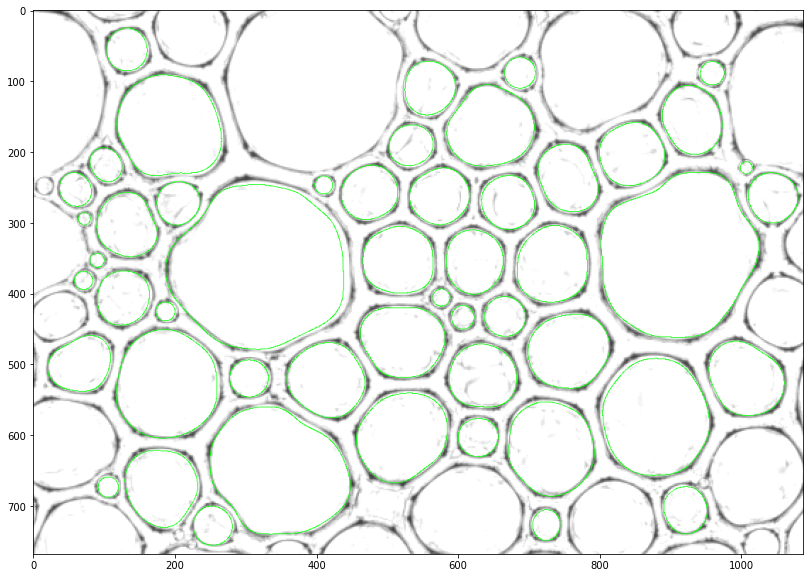

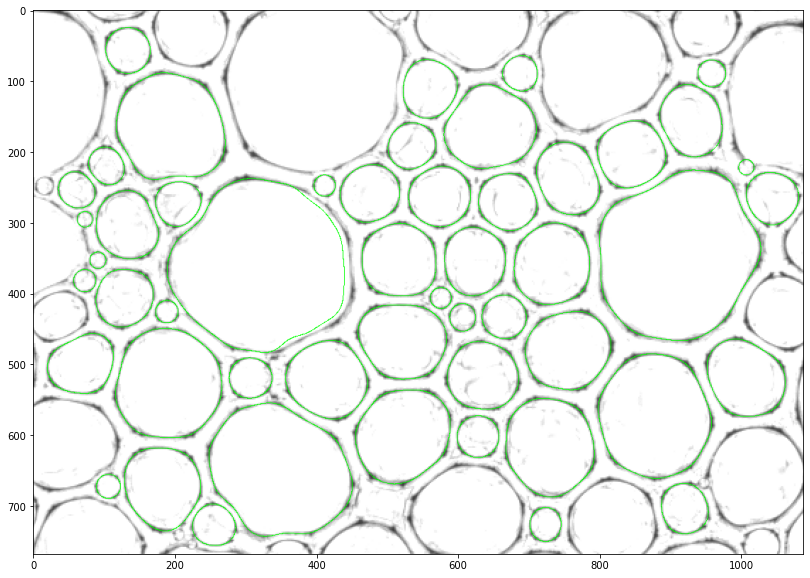

In [ ]:
i=0
for image_name in file_names:
  mask_path=os.path.join('/content', 'mask_of_'+image_name[:-3]+'png')
  mask=cv2.imread(mask_path,0)
  mask=-(mask-255)
  labels = qbubbleLabels(mask)
  lv1 =  qbubbleLabelsContours(labels)
  lv2 = qbubbleRefineContours(lv1, images_list[i]/255)
  h, w = mask.shape
  la2 = qbubbleAreas(lv2, w, h)
  plt.figure(figsize=(16, 10))
  qbubblePlot(lv2, images_list[0]/255, s = 1, t = 0,image_name=image_name)
  i=i+1
  file = open(image_name[:-4]+".txt","w")
  file.write("Bubble index and its size\n")
  n=len(la2)
  for k in range(n):
    file.write(str(k)+"  "+str(la2[k])+"\n")
  file.close()

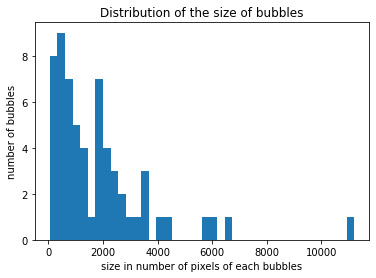

In [ ]:
plt.hist(la2,bins = 40)
plt.xlabel('size in number of pixels of each bubbles')
plt.ylabel('number of bubbles')
plt.title('Distribution of the size of bubbles')
plt.savefig("/content/size_distribution.png")